# MVP Pipeline de Dados
## Pesquisa sobre aparelhos celulares

Edmilson Prata da Silva

PUC-RJ - MBA em Ciência de Dados e Analytics

Disciplina de Engenharia de Dados

## Métricas e Graficos

## Imports

Imports das bibliotecas necessárias para o funcionamento do script.

In [0]:
import re
import uuid
import warnings
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

## Carga de Dados

Os dados serão carregados a partir da camada gold na qual as métricas já estão prontas para consumo.

In [0]:
spark = SparkSession.builder.getOrCreate()
company_metrics = spark.table("gold.company_metrics")
company_metrics.printSchema()

root
 |-- company_id: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- mean_price: integer (nullable = true)
 |-- max_price: integer (nullable = true)
 |-- min_price: integer (nullable = true)
 |-- mean_battery: integer (nullable = true)
 |-- max_battery: integer (nullable = true)
 |-- min_battery: integer (nullable = true)
 |-- mean_screen_size: decimal(10,2) (nullable = true)
 |-- max_screen_size: decimal(10,2) (nullable = true)
 |-- min_screen_size: decimal(10,2) (nullable = true)
 |-- mean_ram: decimal(10,2) (nullable = true)
 |-- max_ram: decimal(10,2) (nullable = true)
 |-- min_ram: decimal(10,2) (nullable = true)



In [0]:
model_metrics = spark.table("gold.model_metrics")
model_metrics.printSchema()

root
 |-- model_id: string (nullable = true)
 |-- model_name: string (nullable = true)
 |-- company_id: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- ranking: integer (nullable = true)
 |-- characteristic_label: string (nullable = true)
 |-- characteristic_unit: string (nullable = true)
 |-- characteristic_value: decimal(10,2) (nullable = true)



In [0]:
segmentation_metrics = spark.table("gold.segmentation_metrics")
segmentation_metrics.printSchema()

root
 |-- segmentation_code: string (nullable = true)
 |-- segmentation_name: string (nullable = true)
 |-- range1_name: string (nullable = true)
 |-- range2_name: string (nullable = true)
 |-- range3_name: string (nullable = true)
 |-- range1_qtd: integer (nullable = true)
 |-- range2_qtd: integer (nullable = true)
 |-- range3_qtd: integer (nullable = true)



In [0]:
# Converte DataFrame Spark em Pandas, otimizando com Apache Arrow
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
company_pd = company_metrics.toPandas()
model_pd = model_metrics.toPandas()
segmentation_pd = segmentation_metrics.toPandas()

company_pd['max_ram'] = company_pd['max_ram'].apply(lambda x: float(x))
company_pd['mean_ram'] = company_pd['mean_ram'].apply(lambda x: float(x))
company_pd['min_ram'] = company_pd['min_ram'].apply(lambda x: float(x))
company_pd['max_screen_size'] = company_pd['max_screen_size'].apply(lambda x: float(x))
company_pd['mean_screen_size'] = company_pd['mean_screen_size'].apply(lambda x: float(x))
company_pd['min_screen_size'] = company_pd['min_screen_size'].apply(lambda x: float(x))
model_pd['characteristic_value'] = model_pd['characteristic_value'].apply(lambda x: float(x))

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [mean_screen_size, max_screen_size, min_screen_size, mean_ram, max_ram, min_ram] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [characteristic_value] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


## Métodos para gráficos

Métodos para faciliar a construção de gráficos e deixar o código mais limpo.

In [0]:
def line_graphic(
    data: pd.DataFrame,
    title: str = 'Graphic Title',
    xlabel: str = 'X Axis Label',
    ylabel: str = 'Y Axis Label',
    xlabel_rotation: int = 0,
    ylabel_rotation: int = 0,
    grid_color: str = '#95a5a6',
    linestyle: str = '--',
    alpha: float = 0.7,
    figsize = (10, 3),
    log_scale_adjust: bool = False
):
    fig, grafico = plt.subplots(figsize=figsize)
    data.plot(kind='line', marker='o', ax=grafico)

    grafico.set_title(title)
    grafico.set_xlabel(xlabel)
    grafico.set_ylabel(ylabel)
    grafico.set_xticks(ticks=range(0, data.index.size))
    grafico.set_xticklabels(labels=data.index, rotation=xlabel_rotation)
    plt.setp(grafico.get_yticklabels(), rotation=ylabel_rotation)

    if log_scale_adjust: # For exponencial values
        grafico.set_yscale('log')

    grafico.grid(
        color=grid_color,
        linestyle=linestyle,
        linewidth=2, 
        axis='y',
        alpha=alpha, 
        visible=True
    )

def bar_graphic(
    data: pd.DataFrame,
    title: str = 'Graphic Title',
    xlabel: str = 'X Axis Label',
    ylabel: str = 'Y Axis Label',
    xlabel_rotation: int = 0,
    ylabel_rotation: int = 0,
    grid_color: str = '#95a5a6',
    linestyle: str = '--',
    alpha: float = 0.7,
    figsize: tuple = (10, 3),
    log_scale_adjust: bool = False,
    bar_color: str = 'skyblue',
    bar_width: float = 0.8,
):
    fig, grafico = plt.subplots(figsize=figsize)
    
    data.plot(
        kind='bar',
        ax=grafico,
        color=bar_color,
        width=bar_width,
        edgecolor='black',  # borders of bars
        alpha=0.8,  # bar transparency
    )

    grafico.set_title(title)
    grafico.set_xlabel(xlabel)
    grafico.set_ylabel(ylabel)
    grafico.set_xticks(ticks=range(0, data.index.size))
    grafico.set_xticklabels(labels=data.index, rotation=xlabel_rotation)
    plt.setp(grafico.get_yticklabels(), rotation=ylabel_rotation)

    if log_scale_adjust:
        grafico.set_yscale('log')

    grafico.grid(
        color=grid_color,
        linestyle=linestyle,
        linewidth=2,
        axis='y',
        alpha=alpha,
        visible=True
    )

    # Add value labels on top of bars
    for p in grafico.patches:
        grafico.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )
        
    return grafico

def line_graph(data, col_index, col_labels, col_values, title, xlabel, ylabel, rotation: int = 0):
    df = data.iloc[0:,[col_index]]
    df = df.set_index(data[col_labels])
    df.sort_values(by=col_values, inplace=True, ascending=False)
    line_graphic(title=title, xlabel=xlabel, ylabel=ylabel, data=df, figsize=(17,4), xlabel_rotation=rotation)

## Métricas de Preço por Empresa

Métricas de negócio relacionadas à preço por empresa concorrente:

1. Preço médio, mais alto e mais baixo por empresa: Qual é o smartphone mais caro e mais barato em cada país?

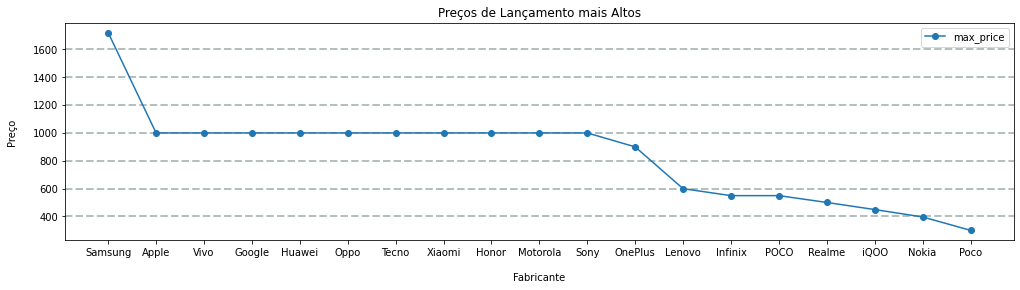

In [0]:
line_graph(company_pd, 3, 'company_name', 'max_price', 'Preços de Lançamento mais Altos', '\nFabricante', 'Preço\n')

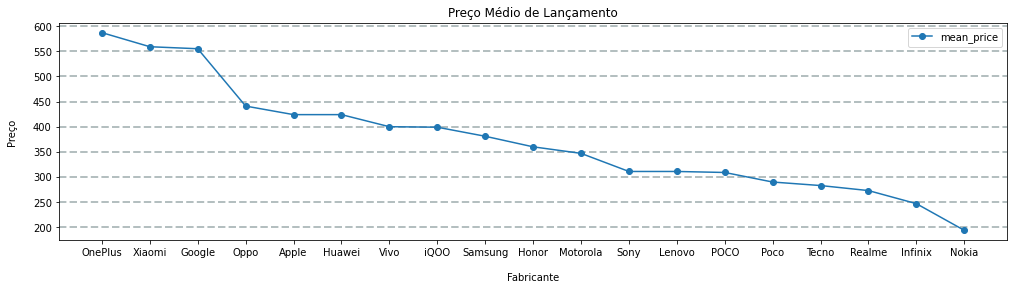

In [0]:
line_graph(company_pd, 2, 'company_name', 'mean_price', 'Preço Médio de Lançamento', '\nFabricante', 'Preço\n')

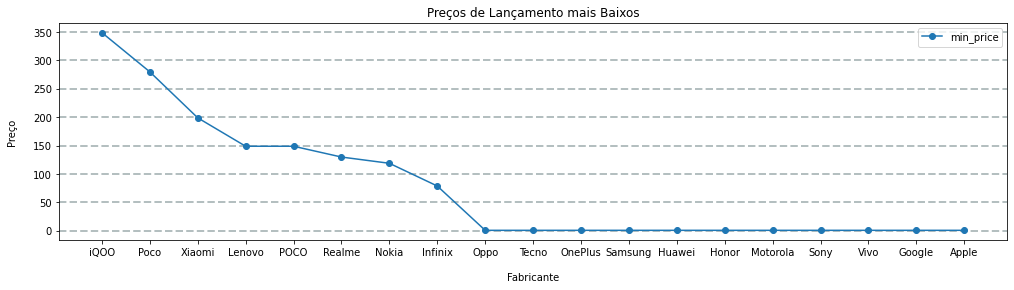

In [0]:
line_graph(company_pd, 4, 'company_name', 'min_price', 'Preços de Lançamento mais Baixos', '\nFabricante', 'Preço\n')

## Métricas Técnicas por Empresa

1. Média, mínimo e máximo da capacidade da bateria por empresa;
2. Média, mínimo e máximo do tamanho de tela dos smartphones por empresa;
3. Média, mínimo e máximo da memória RAM dos smartphones por empresa;

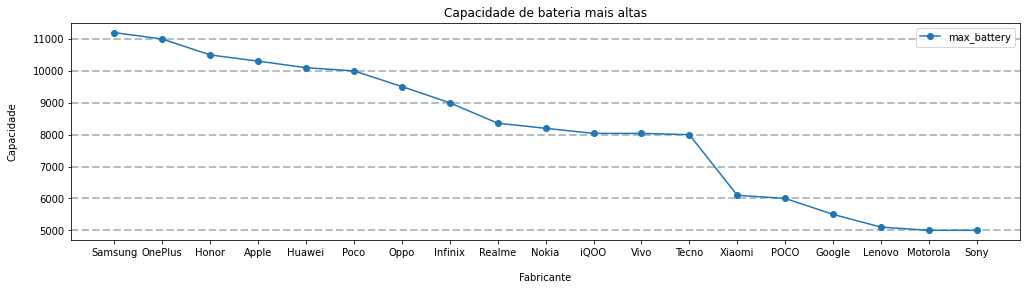

In [0]:
line_graph(company_pd, 6, 'company_name', 'max_battery', 'Capacidade de bateria mais altas', '\nFabricante', 'Capacidade\n')

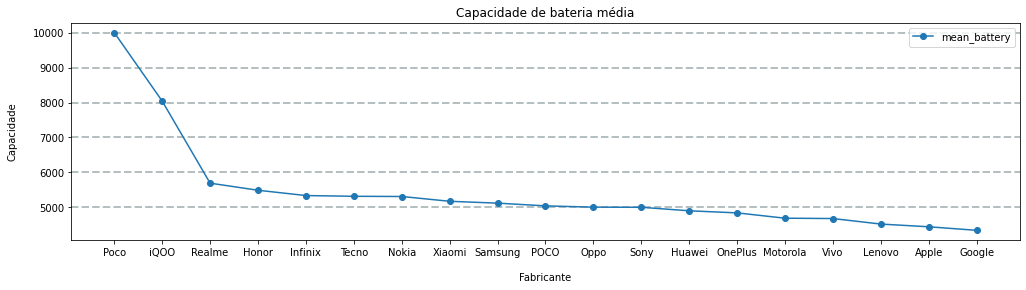

In [0]:
line_graph(company_pd, 5, 'company_name', 'mean_battery', 'Capacidade de bateria média', '\nFabricante', 'Capacidade\n')

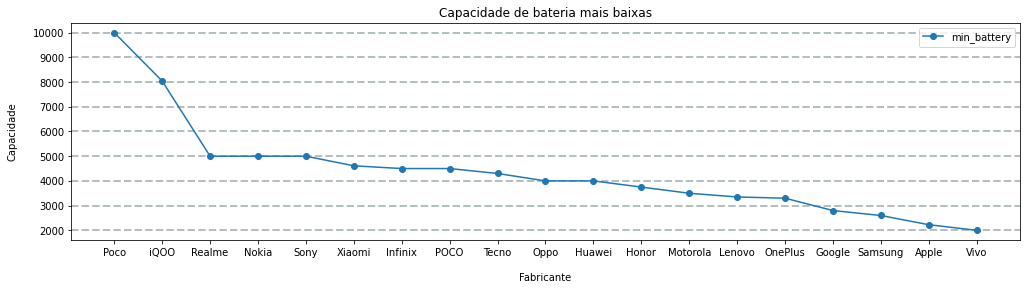

In [0]:
line_graph(company_pd, 7, 'company_name', 'min_battery', 'Capacidade de bateria mais baixas', '\nFabricante', 'Capacidade\n')

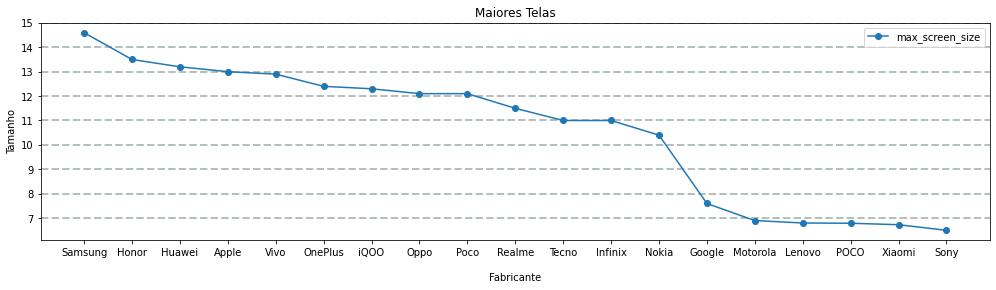

In [0]:
line_graph(company_pd, 9, 'company_name', 'max_screen_size', 'Maiores Telas', '\nFabricante', 'Tamanho')

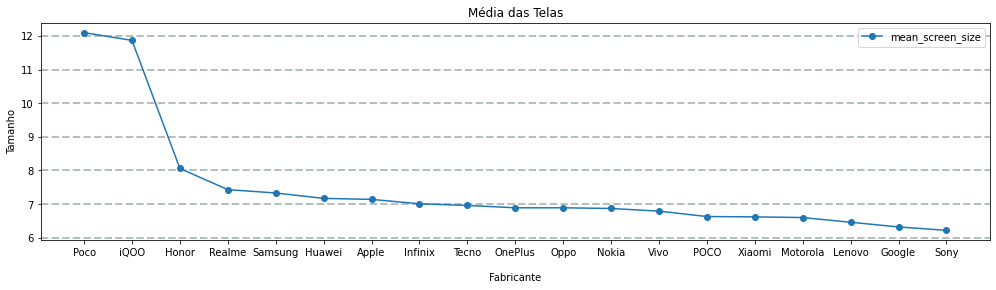

In [0]:
line_graph(company_pd, 8, 'company_name', 'mean_screen_size', 'Média das Telas', '\nFabricante', 'Tamanho')

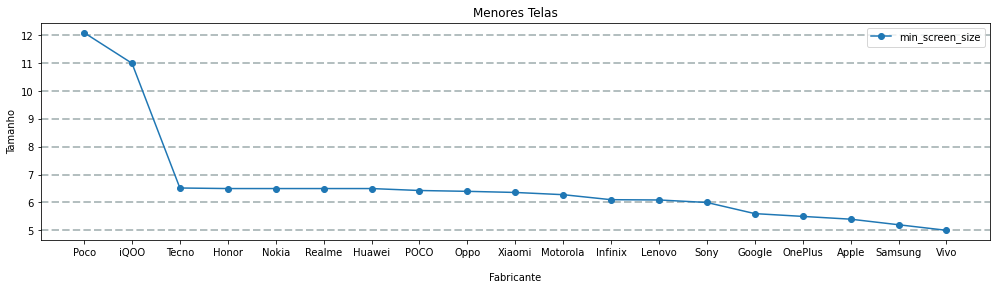

In [0]:
line_graph(company_pd, 10, 'company_name', 'min_screen_size', 'Menores Telas', '\nFabricante', 'Tamanho')

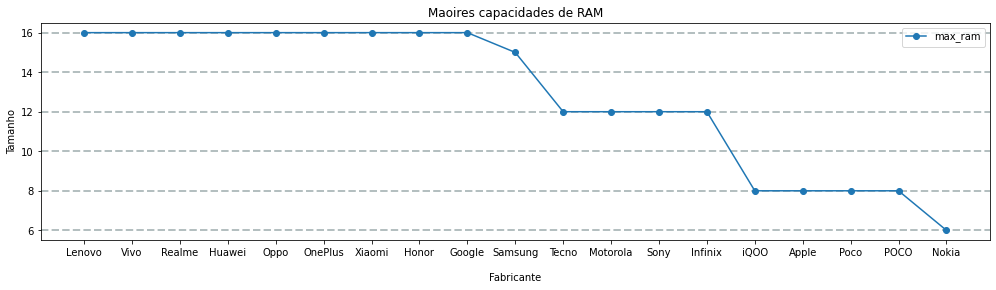

In [0]:
line_graph(company_pd, 12, 'company_name', 'max_ram', 'Maoires capacidades de RAM', '\nFabricante', 'Tamanho')

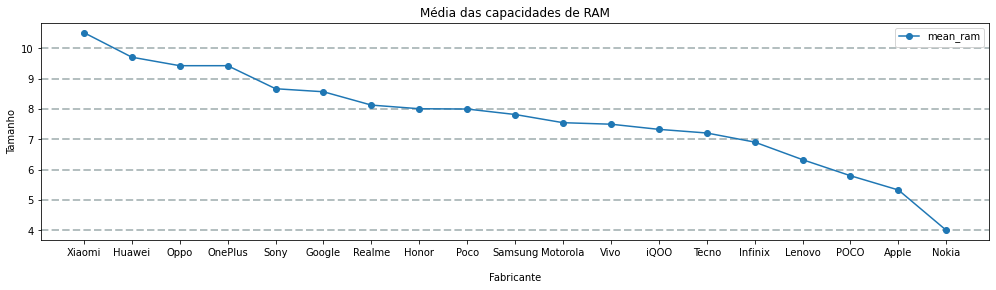

In [0]:
line_graph(company_pd, 11, 'company_name', 'mean_ram', 'Média das capacidades de RAM', '\nFabricante', 'Tamanho')

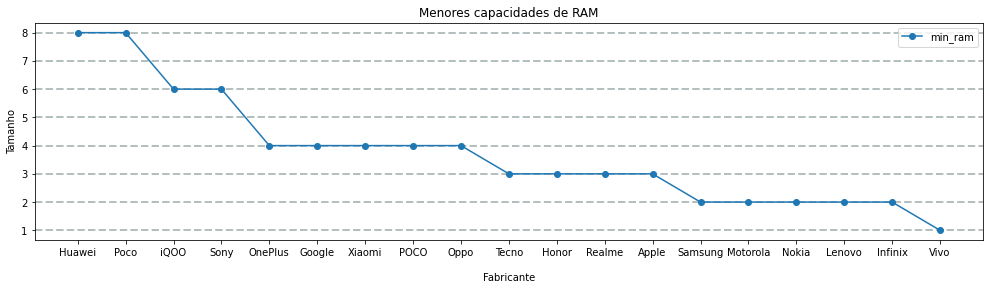

In [0]:
line_graph(company_pd, 13, 'company_name', 'min_ram', 'Menores capacidades de RAM', '\nFabricante', 'Tamanho')

## Métricas de Desempenho – TOP TEN

1. Smartphones com maior capacidade de bateria;
2. Smartphones com maior memória RAM;
3. Smartphones com melhor câmera traseira.

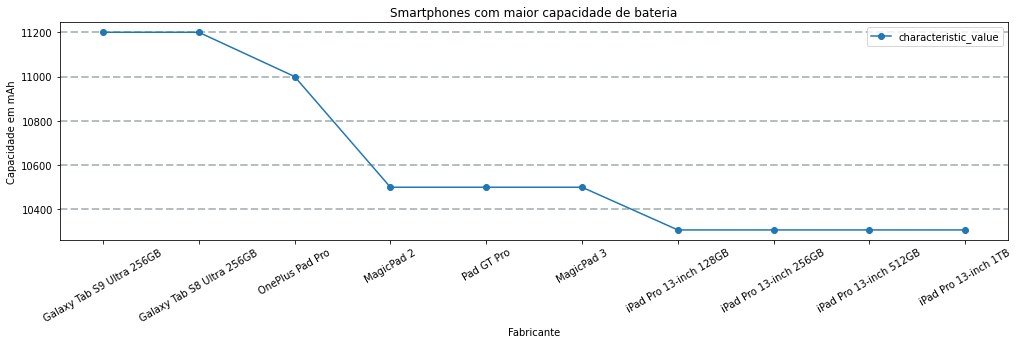

In [0]:
line_graph(model_pd[model_pd['characteristic_label'] == 'Battery Capacity'], 7, 'model_name', 'characteristic_value', 'Smartphones com maior capacidade de bateria', 'Fabricante', 'Capacidade em mAh', rotation=30)

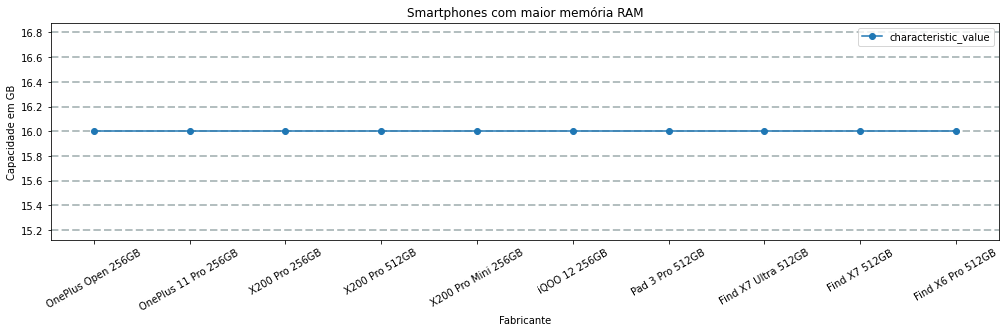

In [0]:
line_graph(model_pd[model_pd['characteristic_label'] == 'RAM'], 7, 'model_name', 'characteristic_value', 'Smartphones com maior memória RAM', 'Fabricante', 'Capacidade em GB', rotation=30)

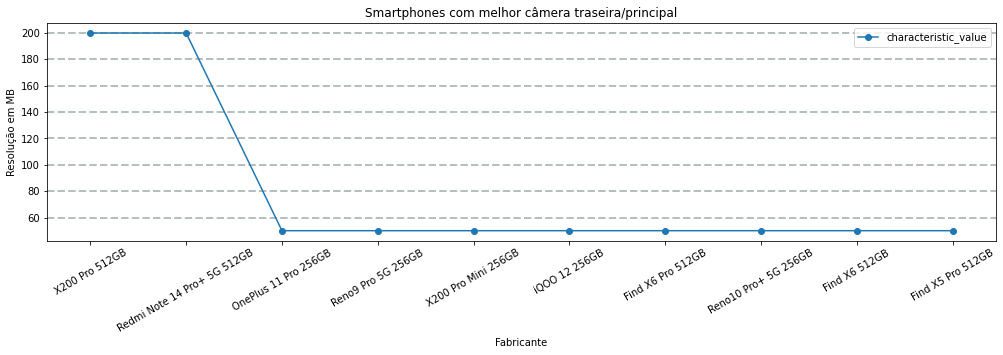

In [0]:
line_graph(model_pd[model_pd['characteristic_label'] == 'Back Camera'], 7, 'model_name', 'characteristic_value', 'Smartphones com melhor câmera traseira/principal', 'Fabricante', 'Resolução em MB', rotation=30)

## Métricas de Segmentação

1. Smartphones por Faixa de Preço, sendo: abaixo de U$ 200, entre U$ 200 e U$ 500 ou acima de U$ 500.
2. Smartphones por Tamanho de Tela, sendo: pequena, sendo < 6"; médias, entre 6" e 6.5"; ou grandes, > 6.5"?
3. Distribuição dos smartphones por quantidade de memória RAM.

Out[154]: <AxesSubplot:title={'center':'Smartphones por Faixa de Preço'}, xlabel='\nFaixa de Preço', ylabel='Quantidade'>

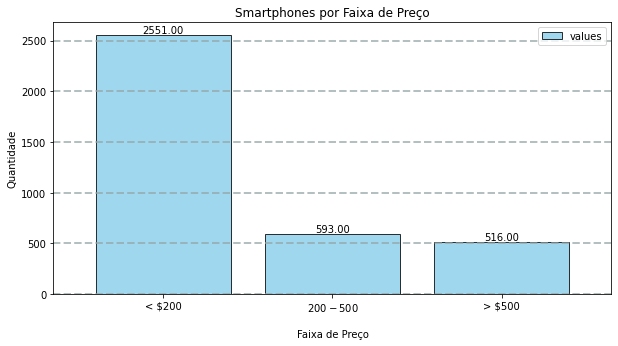

In [0]:
df = pd.DataFrame()
df['values'] = segmentation_pd.iloc[1,5:8]
df.index = segmentation_pd.iloc[1,2:5]
bar_graphic(data=df, title='Smartphones por Faixa de Preço', xlabel='\nFaixa de Preço', ylabel='Quantidade', figsize=(10,5))

Out[155]: <AxesSubplot:title={'center':'Smartphones por Tamanho de Tela'}, xlabel='\nFaixa de Tamanho', ylabel='Quantidade'>

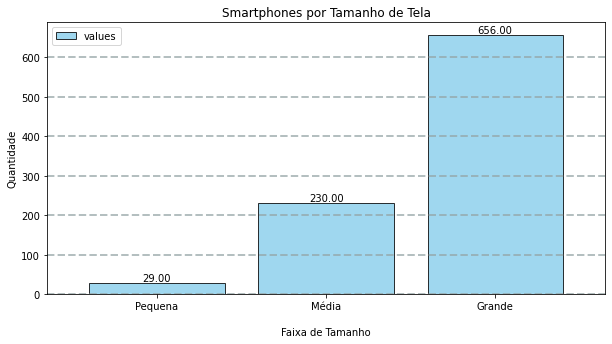

In [0]:
df = pd.DataFrame()
df['values'] = segmentation_pd.iloc[2,5:8]
df.index = segmentation_pd.iloc[2,2:5]
bar_graphic(data=df, title='Smartphones por Tamanho de Tela', xlabel='\nFaixa de Tamanho', ylabel='Quantidade', figsize=(10,5))

Out[156]: <AxesSubplot:title={'center':'Distribuição dos smartphones por quantidade de memória RAM'}, xlabel='\nFaixa de Capacidade', ylabel='Quantidade'>

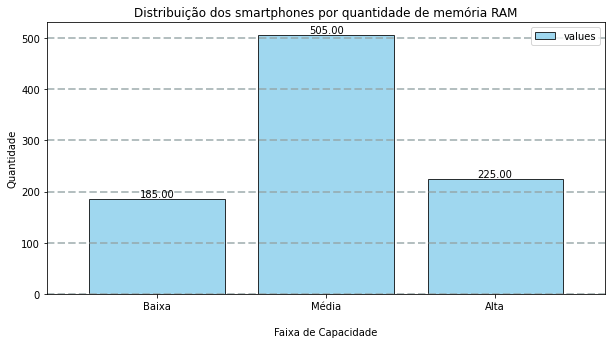

In [0]:
df = pd.DataFrame()
df['values'] = segmentation_pd.iloc[0,5:8]
df.index = segmentation_pd.iloc[0,2:5]
bar_graphic(data=df, title='Distribuição dos smartphones por quantidade de memória RAM', xlabel='\nFaixa de Capacidade', ylabel='Quantidade', figsize=(10,5))